## 一、生成神经网络训练样本
### 1、通过聚类，将背景像素和花生(包括花生壳和花生仁)像素进行区分。将背景像素置为0，花生像素置为255
### 2、使用连通域算法，提取花生所在区域，并保存
### 3、手动将花生图片划分为花生壳、花生仁两个类别(已划分好，并放在本目录下的peanute文件夹下)

In [45]:
import os

import numpy as np
import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [35]:
def read_picture(file_root='cube_20221019_091444'):
    # 图片文件夹路径
    current_path = os.getcwd()
    folder_path = os.path.join(current_path,'peanut_traning_data',file_root, 'png' )

    # 读取图片
    image_list = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.png'):
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # 以灰度模式读取图片
            image_list.append(image)

    # 将图片转换为NumPy数组
    image_array = np.array(image_list)

    return image_array, image

In [36]:
def KmCluster(image_array):
    """
    聚类，将输入图片中的花生壳、花生区域的像素置为255，背景区域像素值置为0
    """
    data = image_array
    # 将数据重新形状为 (N, M)，其中 N 是样本数，M 是特征数
    N, M = data.shape[0], data.shape[1] * data.shape[2]
    reshaped_data = data.reshape(N, M)
    reshaped_data = np.transpose(reshaped_data, (1, 0))

    # 使用KMeans算法进行聚类，聚类成三类
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(reshaped_data)

    # 获取聚类结果标签
    labels = kmeans.labels_
    print(labels.shape)
    # 将聚类结果标签重新形状为3x1024x1280的数组
    reshaped_labels = labels.reshape(1, 1024, 1280)
    if np.count_nonzero(reshaped_labels == 1) > np.count_nonzero(reshaped_labels == 0):
        reshaped_labels = np.where(reshaped_labels == 1, 0, 1)

    # 创建一个3x1024x1280的图片，将聚类结果标签赋值给对应位置的像素
    image = np.zeros((3, 1024, 1280))
    image[0][reshaped_labels[0] == 0] = 0  # 第一类赋值为255
    image[1][reshaped_labels[0] == 1] = 255  # 第二类赋值为255
    image[2][reshaped_labels[0] == 2] = 255  # 第三类赋值为255

    # 显示图片
    image = np.transpose(image, (1, 2, 0)).astype(np.uint8)
    plt.imshow(image)
    plt.show()
    return image

In [37]:
def generate_img(image, img):
    """
    生成花生壳、花生粒样本，然后手动打标签
    """
    global j
    # 读取灰度图像
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(image, 20, 100)

    # 进行连通区域分析，提取物体轮廓
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 遍历每个轮廓，生成小图片
    for i, contour in enumerate(contours):
        # 获取每个轮廓的边界框
        x, y, w, h = cv2.boundingRect(contour)

        # 提取小图片
        if w>=30 and h>=30:
            object_image = img[y:y+h, x:x+w]
            object_image = cv2.resize(object_image, (64, 64))
            # 保存小图片
            cv2.imwrite(f'{j}.jpg', object_image)
            j = j + 1


(1310720,)


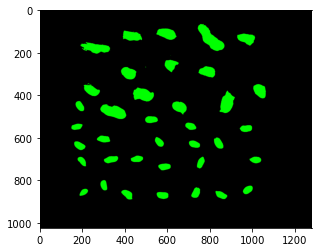

(1310720,)


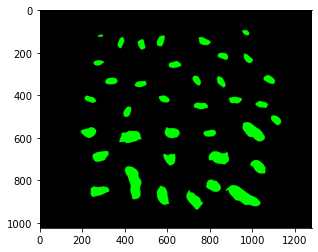

(1310720,)


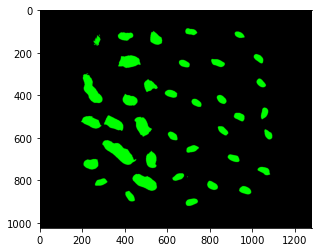

(1310720,)


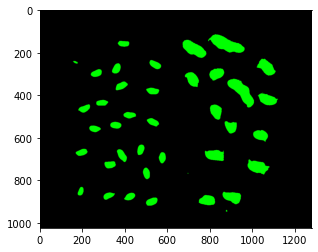

(1310720,)


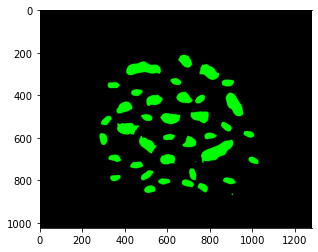

(1310720,)


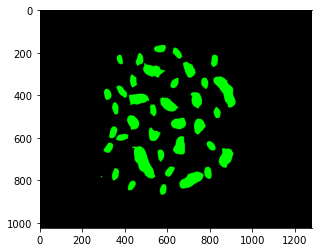

(1310720,)


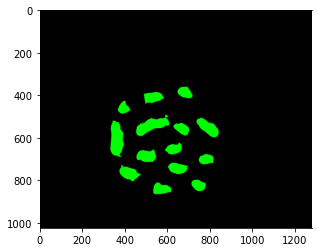

(1310720,)


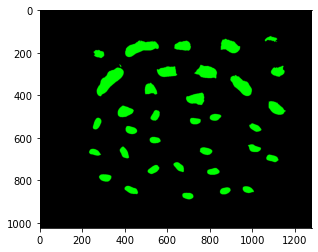

(1310720,)


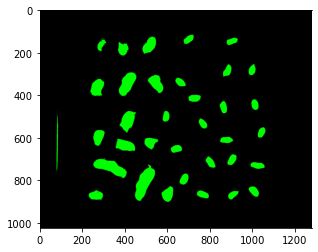

(1310720,)


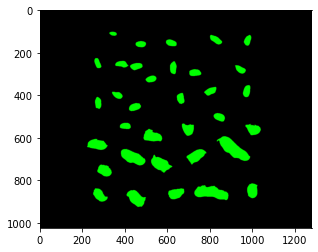

(1310720,)


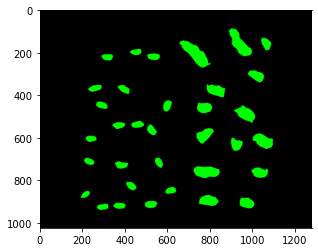

(1310720,)


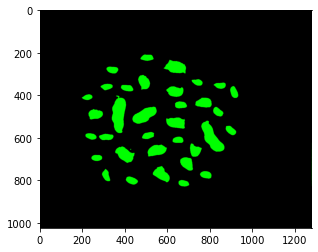

(1310720,)


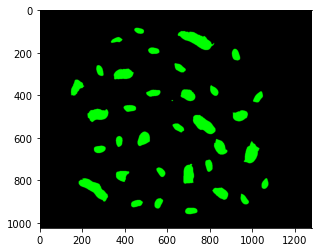

(1310720,)


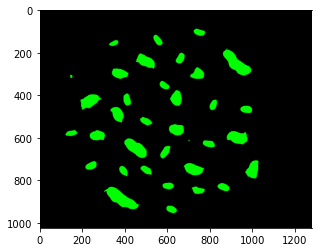

(1310720,)


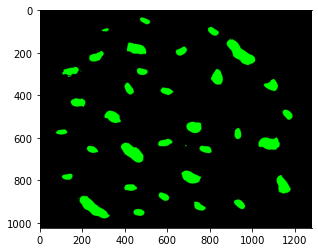

(1310720,)


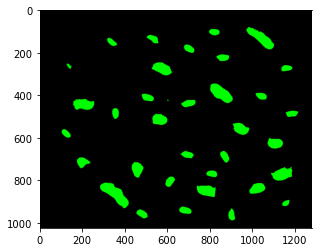

(1310720,)


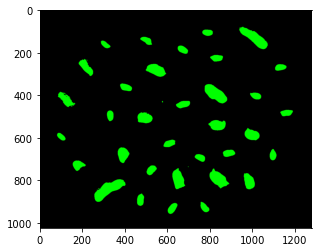

(1310720,)


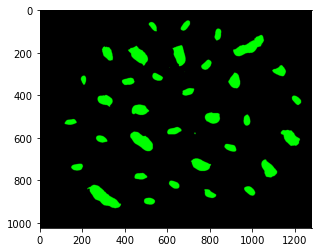

(1310720,)


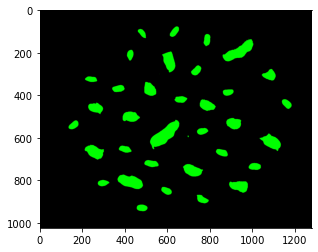

(1310720,)


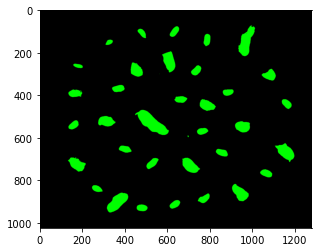

(1310720,)


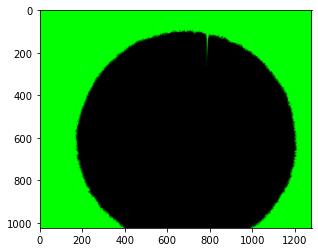

In [38]:
j = 0
current_path = os.getcwd()
folder_path = os.path.join(current_path,'peanut_traning_data' )
for file_root in os.listdir(folder_path):
    image, img = read_picture(file_root=file_root)
    image = KmCluster(image)
    generate_img(image, img)

## 二、训练神经网络识别花生仁和花生壳

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models

In [40]:
# 定义数据预处理的转换
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # 调整图像大小为64x64像素
    transforms.ToTensor(),  # 转换为张量
    transforms.Normalize((0.5,), (0.5,))  # 归一化处理
])

In [41]:
# 加载数据集
dataset = ImageFolder('peanute', transform=transform)

# 划分训练集和测试集
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [42]:
# 定义神经网络模型
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.res = models.resnet18(pretrained=True)
        self.fc1 = nn.Linear(1000, 2)

    def forward(self, x):
        x = self.res(x)
        x = self.fc1(x)
        return x

model = Net()

In [43]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00002)

In [44]:
# 进行训练
num_epochs = 500
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
best_acc = 0

for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # 进行测试
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Accuracy: {100 * correct / total:.2f}%")
        
        if correct / total >= best_acc:
            best_acc = correct / total
            torch.save(model.state_dict(), 'best.mdl')
    
    # early stop
    if best_acc >= 0.99:
        break

Epoch [1/500], Loss: 0.5014
Accuracy: 77.27%
Epoch [2/500], Loss: 0.0802
Accuracy: 92.42%
Epoch [3/500], Loss: 0.0307
Accuracy: 92.42%
Epoch [4/500], Loss: 0.0182
Accuracy: 95.45%
Epoch [5/500], Loss: 0.0140
Accuracy: 97.73%
Epoch [6/500], Loss: 0.0091
Accuracy: 96.97%
Epoch [7/500], Loss: 0.0153
Accuracy: 97.73%
Epoch [8/500], Loss: 0.0090
Accuracy: 97.73%
Epoch [9/500], Loss: 0.0041
Accuracy: 96.97%
Epoch [10/500], Loss: 0.0204
Accuracy: 96.21%
Epoch [11/500], Loss: 0.0049
Accuracy: 96.97%
Epoch [12/500], Loss: 0.0042
Accuracy: 97.73%
Epoch [13/500], Loss: 0.0111
Accuracy: 98.48%
Epoch [14/500], Loss: 0.0061
Accuracy: 98.48%
Epoch [15/500], Loss: 0.0056
Accuracy: 98.48%
Epoch [16/500], Loss: 0.0022
Accuracy: 98.48%
Epoch [17/500], Loss: 0.0174
Accuracy: 98.48%
Epoch [18/500], Loss: 0.0017
Accuracy: 99.24%
